In [15]:
from typing import Callable

import numpy as np
import tensorflow as tf
from keras import Model
from keras.api.models import Sequential

from typing import Callable, Dict

import numpy as np


class ObservationNormalizationCallbacks:
    """
    A collection of static methods and pre-defined callbacks for normalizing observations.

    This class provides utility functions for normalizing observations in reinforcement learning environments.
    It also maintains a dictionary of normalization callbacks for easy selection and extensibility.

    Attributes
    ----------
    normalization_callbacks : Dict[str, Callable[[np.ndarray], np.ndarray]]
        A dictionary mapping normalization types (keys) to their respective callback functions (values).

    Methods
    -------
    non_normalize(observations: np.ndarray) -> np.ndarray
        Returns the observations without applying any normalization.

    normalize_images(observations: np.ndarray) -> np.ndarray
        Normalizes image-like observations by scaling pixel values to the range [0, 1].
    """

    @staticmethod
    def non_normalize(observations: np.ndarray) -> np.ndarray:
        """
        Returns the observations without applying any normalization.

        Parameters
        ----------
        observations : np.ndarray
            The raw observations from the environment.

        Returns
        -------
        np.ndarray
            The unmodified observations.
        """
        return observations

    @staticmethod
    def normalize_images(observations: np.ndarray) -> np.ndarray:
        """
        Normalizes image-like observations by scaling pixel values to the range [0, 1].

        Parameters
        ----------
        observations : np.ndarray
            The raw image-like observations, typically with pixel values in the range [0, 255].

        Returns
        -------
        np.ndarray
            The normalized observations with pixel values in the range [0, 1].
        """
        return observations / 255

    normalization_callbacks: Dict[str, Callable[[np.ndarray], np.ndarray]] = {
        "no_normalization": non_normalize,
        "image": normalize_images,
    }



class ModelActivationObtainer:
    """
    A utility class for obtaining activations from layers of a Keras sequential model.

    This class creates intermediate models to fetch the activations from each layer
    of a given Keras Sequential model for provided inputs. It also flattens activations
    for Conv2D layers.

    Parameters
    ----------
    model : Sequential
        The Keras Sequential model whose layer activations will be extracted.
    input_normalization_type: str
        The normaliaztion type to use for the model inputs

    Raises
    ------
    ValueError
        If the `normalization_type` is not a valid key in
        `ObservationNormalizationCallbacks.normalization_callbacks`.

    """

    def __init__(self, model: Sequential, input_normalization_type: str) -> None:
        self.model: Sequential = model
        if (
            input_normalization_type
            not in ObservationNormalizationCallbacks.normalization_callbacks.keys()
        ):
            raise ValueError(
                f'"{input_normalization_type}" is not a valid argument for normalization_type. Valid arguments: {[type for type in ObservationNormalizationCallbacks.normalization_callbacks.keys()]}'
            )
        self.input_normalization_callback: Callable[[np.ndarray], np.ndarray] = (
            ObservationNormalizationCallbacks.normalization_callbacks[input_normalization_type]
        )
        self._activation_models = {
            layer_index: self._create_activation_model(layer_index=layer_index)
            for layer_index in range(len(model.layers))
        }

    def _create_activation_model(self, layer_index: int) -> Model:
        """
        Create an intermediate model to extract activations from a specific layer.

        Parameters
        ----------
        layer_index : int
            The index of the layer in the Sequential model.

        Returns
        -------
        Model
            A Keras Model that outputs the activations of the specified layer.
        """
        return Model(
            inputs=self.model.layers[0].input,
            outputs=self.model.layers[layer_index].output,  # type: ignore
        )

    def get_layer_activations(
        self, layer_index: int, model_inputs: np.ndarray, flatten: bool
    ) -> np.ndarray:
        """
        Get the activations from a specific layer for the given inputs.

        This method uses the intermediate model for the specified layer to compute
        the activations. If the layer is a Conv2D layer, the activations are flattened
        into a 2D array.

        Parameters
        ----------
        layer_index : int
            The index of the layer whose activations are to be fetched.
        model_inputs : np.ndarray
            The inputs to the model for which activations are computed.
            The shape of this array should match the model's input shape.
        flatten : bool
            Whether to flatten activations, applicable for Conv2D layers

        Returns
        -------
        np.ndarray
            The activations from the specified layer. If the layer is a Conv2D layer,
            the activations are flattened to a shape of `(batch_size, flattened_activations)`.

        Notes
        -----
        Conv2D layer activations are reshaped from `(batch_size, height, width, channels)`
        to `(batch_size, height * width * channels)`.
        """
        activation_model: Model = self._activation_models[layer_index]
        inputs_normalized = self.input_normalization_callback(np.array(model_inputs))
        activations = activation_model.predict(inputs_normalized)

        # If the layer is a Conv2D layer, flatten the output
        if flatten and len(activations.shape) == 4:
            batch_size, height, width, channels = activations.shape
            activations = activations.reshape(batch_size, height * width * channels)

        return activations


In [16]:
import numpy as np
import pandas as pd

def find_top_unique_concepts(environments, methods, layers, data_dir="../../cav_alignment_data"):
    """
    Find the top two unique concepts with highest cosine similarity for each method in each environment.

    Parameters
    ----------
    environments : list of str
        Names of the environments to process.
    methods : list of str
        Clustering methods to consider (e.g., "ice", "fc_means", "k_means").
    layers : list of int
        Layer indices whose CSV files should be read.
    data_dir : str, optional
        Base directory where `<environment>_layer_<layer>_matches_{avg,sum}.csv` live.

    Returns
    -------
    dict
        Nested dictionary mapping
        `{ environment: { method: [top1_dict, top2_dict], ...}, ... }`
        where each `top*_dict` has keys
        `'layer'`, `'batch'`, `'cavs_n'`, `'matched_index'`, 
        `'cosine_similarity'`, `'manual_concept_name'`.
    """
    results = {}

    for env in environments:
        results[env] = {}
        for method in methods:
            all_rows = []
            for layer in layers:
                for metric in ("avg", "sum"):
                    path = f"{data_dir}/{env}_layer_{layer}_matches_{metric}.csv"
                    df = pd.read_csv(path)
                    df_m = df[df["method"] == method]
                    if not df_m.empty:
                        # include 'batch' now as well
                        df_sel = df_m[[
                            "layer", "batch", "cavs_n", "matched_index",
                            "cosine_similarity", "manual_concept_name"
                        ]]
                        all_rows.append(df_sel)
            if all_rows:
                df_all = pd.concat(all_rows, ignore_index=True)
                df_sorted = df_all.sort_values("cosine_similarity", ascending=False)
                df_unique = df_sorted.drop_duplicates(subset=["manual_concept_name"])
                top2 = df_unique.head(2)
                results[env][method] = top2.to_dict("records")
            else:
                results[env][method] = []

    return results


if __name__ == "__main__":
    environments = ["gem_collector", "minecart_counter", "gold_run_mini"]
    methods = ["ice", "fc_means", "k_means"]
    layers = [0, 1, 3, 4, 5]

    top_concepts = find_top_unique_concepts(environments, methods, layers)

    for env in environments:
        for method, recs in top_concepts[env].items():
            print(f"\nEnvironment={env}, Method={method}")
            for i, r in enumerate(recs, 1):
                print(
                    f"  Top {i}: layer={r['layer']}, batch={r['batch']}, cavs_n={r['cavs_n']}, "
                    f"matched_index={r['matched_index']}, "
                    f"cosine_similarity={r['cosine_similarity']:.4f}, "
                    f"{r['manual_concept_name']!r}"
                )



environments = ["gem_collector", "minecart_counter", "gold_run_mini"]
methods = ["ice", "fc_means", "k_means"]
layers = [0, 1, 3, 4, 5]

top_concepts = find_top_unique_concepts(environments, methods, layers)

for environment in environments:
    for method, recs in top_concepts[environment].items():
        print(f"\nEnvironment={environment}, Method={method}")
        for i, r in enumerate(recs, 1):
            print(f"  Top {i}: layer={r['layer']}, cavs_n={r['cavs_n']}, "
                    f"matched_index={r['matched_index']}, "
                    f"cosine_similarity={r['cosine_similarity']:.4f}, "
                    f"{r['manual_concept_name']!r}")
        





Environment=gem_collector, Method=ice
  Top 1: layer=1, batch=60, cavs_n=4, matched_index=1, cosine_similarity=0.6770, 'aquamarine_right_within_reach'
  Top 2: layer=1, batch=19, cavs_n=49, matched_index=0, cosine_similarity=0.6433, 'amethyst_left_within_reach'

Environment=gem_collector, Method=fc_means
  Top 1: layer=5, batch=8, cavs_n=2, matched_index=0, cosine_similarity=0.3875, 'aquamarine_above'
  Top 2: layer=5, batch=8, cavs_n=2, matched_index=1, cosine_similarity=0.2584, 'aquamarine_left_within_reach'

Environment=gem_collector, Method=k_means
  Top 1: layer=1, batch=61, cavs_n=44, matched_index=2, cosine_similarity=0.8079, 'wall_left'
  Top 2: layer=1, batch=61, cavs_n=44, matched_index=23, cosine_similarity=0.7721, 'aquamarine_above'

Environment=minecart_counter, Method=ice
  Top 1: layer=1, batch=28, cavs_n=2, matched_index=1, cosine_similarity=0.8011, 'minecarts_n'
  Top 2: layer=1, batch=93, cavs_n=36, matched_index=32, cosine_similarity=0.7425, 'wall_1_up_left'

Enviro

In [24]:
import matplotlib.pyplot as plt
from typing import List
import matplotlib.pyplot as plt
import numpy as np
from typing import List
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
from shapely.ops import unary_union
from skimage.morphology import binary_closing, binary_dilation, square

def visualize_avg_cluster_observation(
    clustered_observations: np.ndarray,
    clustered_observations_labels: np.ndarray,
    distances: np.ndarray,
    clusters_to_show: List[int],
    show: bool = True,
    save_file_path: str = "",
) -> None:
    weighted_images = []
    for label in clusters_to_show:
        cluster_idx = np.where(clustered_observations_labels == label)[0]
        cluster_images = clustered_observations[cluster_idx]
        cluster_distances = distances[cluster_idx]

        epsilon = 1e-8
        weights = 1.0 / (cluster_distances + epsilon)
        weights /= weights.sum()

        if cluster_images.ndim == 4:
            weights = weights[:, None, None, None]
        elif cluster_images.ndim == 3:
            weights = weights[:, None, None]
        else:
            raise ValueError("Unexpected image array shape")

        weighted_image = np.sum(cluster_images * weights, axis=0)
        weighted_images.append((weighted_image, label))

    for weighted_image, label in weighted_images:
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow(np.clip(weighted_image, 0, 255).astype(np.uint8))
        #ax.set_title(f"Concept {label}, avg observation")
        ax.axis("off")
        plt.tight_layout()

        if show:
            plt.show()

        if len(save_file_path) > 0:
            plt.savefig(f"{save_file_path}_cluster_{label}.png")

        plt.close()

def force_orthogonality(poly: Polygon) -> Polygon:
    """
    Take a single Polygon and force each exterior edge to be axis-aligned.
    """
    coords = list(poly.exterior.coords)
    if not coords:
        return poly
    snapped = [(round(x), round(y)) for x, y in coords]
    orth_coords = [snapped[0]]
    for pt in snapped[1:]:
        prev = orth_coords[-1]
        if pt[0] != prev[0] and pt[1] != prev[1]:
            orth_coords.append((pt[0], prev[1]))
        orth_coords.append(pt)
    final_coords = [orth_coords[0]]
    for pt in orth_coords[1:]:
        if pt != final_coords[-1]:
            final_coords.append(pt)
    return Polygon(final_coords)


def orthogonal_polygons_from_mask(mask: np.ndarray) -> List[Polygon]:
    """
    Convert a boolean mask into a list of orthogonal polygons for the activated regions.
    """
    h, w = mask.shape
    squares = []
    for r in range(h):
        for c in range(w):
            if mask[r, c]:
                squares.append(Polygon([(c, r), (c + 1, r), (c + 1, r + 1), (c, r + 1)]))
    if not squares:
        return []
    union_poly = unary_union(squares)
    if union_poly.is_empty:
        return []
    if isinstance(union_poly, Polygon):
        union_poly = [union_poly]
    elif union_poly.geom_type == "MultiPolygon":
        union_poly = list(union_poly.geoms) # type: ignore
    orth_polys = []
    for p in union_poly: # type: ignore
        if not p.is_empty:
            orth_p = force_orthogonality(p)
            if not orth_p.is_empty:
                orth_polys.append(orth_p)
    return orth_polys

def visualize_ice_concept(topk_activation_dict, discovery_observations):
    THRESHOLD = 0.5
    PATCH_SIZE = 5
    TOP_N = 6  # Show top 6 observations
    ROWS, COLS = 2, 3  # Arrange them in 2 rows and 3 columns

    for concept_key, records in topk_activation_dict.items():
        concept_id = int(concept_key) if isinstance(concept_key, str) else concept_key

        if not records:
            print(f"No activation maps for concept {concept_id}. Skipping.")
            continue

        # Sort records by average activation and keep top 6
        records = sorted(records, key=lambda r: r["avg_activation"], reverse=True)[:TOP_N]
        n_images = len(records)

        # Create a 2x3 subplot grid.
        fig, axs = plt.subplots(ROWS, COLS, figsize=(COLS * 5, ROWS * 5))
        axs = axs.flatten()

        # Loop over the grid positions; if there are fewer records than TOP_N, hide extra axes.
        for ax, record in zip(axs, records):
            img_idx = record["image_index"]
            activation_map = record["activation_map"]  # shape (h, w)

            # Normalize the activation map.
            hmin, hmax = activation_map.min(), activation_map.max()
            heatmap_norm = (activation_map - hmin) / (hmax - hmin + 1e-8)

            # Threshold the normalized activation map.
            mask = heatmap_norm >= THRESHOLD

            # Perform morphological operations.
            mask_closed = binary_closing(mask, square(3))
            expanded_mask = binary_dilation(mask_closed, square(PATCH_SIZE))

            # Convert the expanded mask into orthogonal polygons.
            polygons = orthogonal_polygons_from_mask(expanded_mask)

            # Display the original image.
            orig_img = discovery_observations[img_idx]
            h_img, w_img = orig_img.shape[:2]
            ax.imshow(orig_img, extent=[0, w_img, h_img, 0], origin="upper")
            ax.set_aspect("equal")

            # Overlay red dots as a sanity check for activated pixels.
            """ activated_pixels = np.argwhere(mask)
            if activated_pixels.size > 0:
                ax.scatter(
                    activated_pixels[:, 1] + 0.5,
                    activated_pixels[:, 0] + 0.5,
                    color="red",
                    s=10,
                    marker="o",
                    alpha=0.7,
                ) """

            # Overlay each polygon boundary.
            if polygons:
                for poly in polygons:
                    if not poly.is_empty:
                        x, y = poly.exterior.xy
                        ax.plot(x, y, color="red", linewidth=2)
            else:
                ax.text(
                    0.5,
                    0.5,
                    "No activation",
                    transform=ax.transAxes,
                    ha="center",
                    va="center",
                    color="red",
                )

            ax.axis("off")
            #ax.set_title(f"Img {img_idx}")

        # Hide any extra subplots if fewer than 6 observations are present.
        for ax in axs[n_images:]:
            ax.set_visible(False)

        plt.suptitle(f"Concept {concept_id} - Top {TOP_N} Observations")
        plt.tight_layout()
        plt.show()

In [18]:
print(top_concepts)

{'gem_collector': {'ice': [{'layer': 1, 'batch': 60, 'cavs_n': 4, 'matched_index': 1, 'cosine_similarity': 0.6770497560501099, 'manual_concept_name': 'aquamarine_right_within_reach'}, {'layer': 1, 'batch': 19, 'cavs_n': 49, 'matched_index': 0, 'cosine_similarity': 0.6433038711547852, 'manual_concept_name': 'amethyst_left_within_reach'}], 'fc_means': [{'layer': 5, 'batch': 8, 'cavs_n': 2, 'matched_index': 0, 'cosine_similarity': 0.3875237841134666, 'manual_concept_name': 'aquamarine_above'}, {'layer': 5, 'batch': 8, 'cavs_n': 2, 'matched_index': 1, 'cosine_similarity': 0.25840051066583, 'manual_concept_name': 'aquamarine_left_within_reach'}], 'k_means': [{'layer': 1, 'batch': 61, 'cavs_n': 44, 'matched_index': 2, 'cosine_similarity': 0.8078690767288208, 'manual_concept_name': 'wall_left'}, {'layer': 1, 'batch': 61, 'cavs_n': 44, 'matched_index': 23, 'cosine_similarity': 0.7720767855644226, 'manual_concept_name': 'aquamarine_above'}]}, 'minecart_counter': {'ice': [{'layer': 1, 'batch': 2

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
GemCollector - k_means
{'layer': 1, 'batch': 61, 'cavs_n': 44, 'matched_index': 2, 'cosine_similarity': 0.8078690767288208, 'manual_concept_name': 'wall_left'}


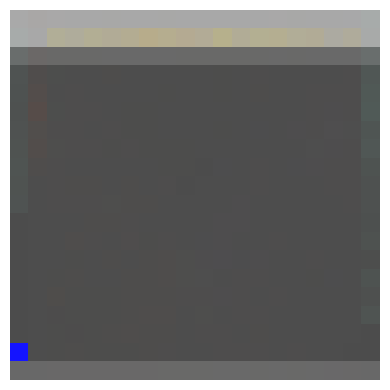

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
GemCollector - k_means
{'layer': 1, 'batch': 61, 'cavs_n': 44, 'matched_index': 23, 'cosine_similarity': 0.7720767855644226, 'manual_concept_name': 'aquamarine_above'}


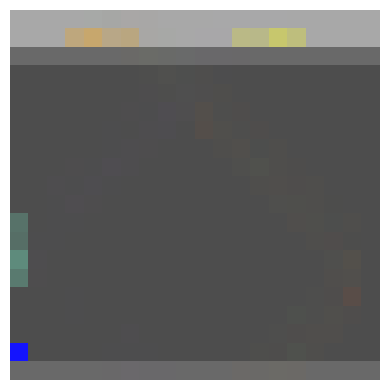

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
GemCollector - fc_means
{'layer': 5, 'batch': 8, 'cavs_n': 2, 'matched_index': 0, 'cosine_similarity': 0.3875237841134666, 'manual_concept_name': 'aquamarine_above'}


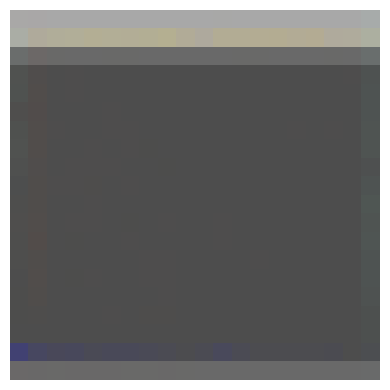

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
GemCollector - fc_means
{'layer': 5, 'batch': 8, 'cavs_n': 2, 'matched_index': 1, 'cosine_similarity': 0.25840051066583, 'manual_concept_name': 'aquamarine_left_within_reach'}


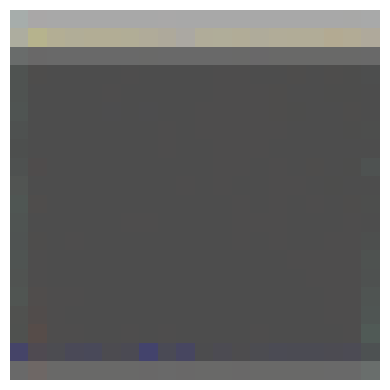

GemCollector - ice
{'layer': 1, 'batch': 60, 'cavs_n': 4, 'matched_index': 1, 'cosine_similarity': 0.6770497560501099, 'manual_concept_name': 'aquamarine_right_within_reach'}


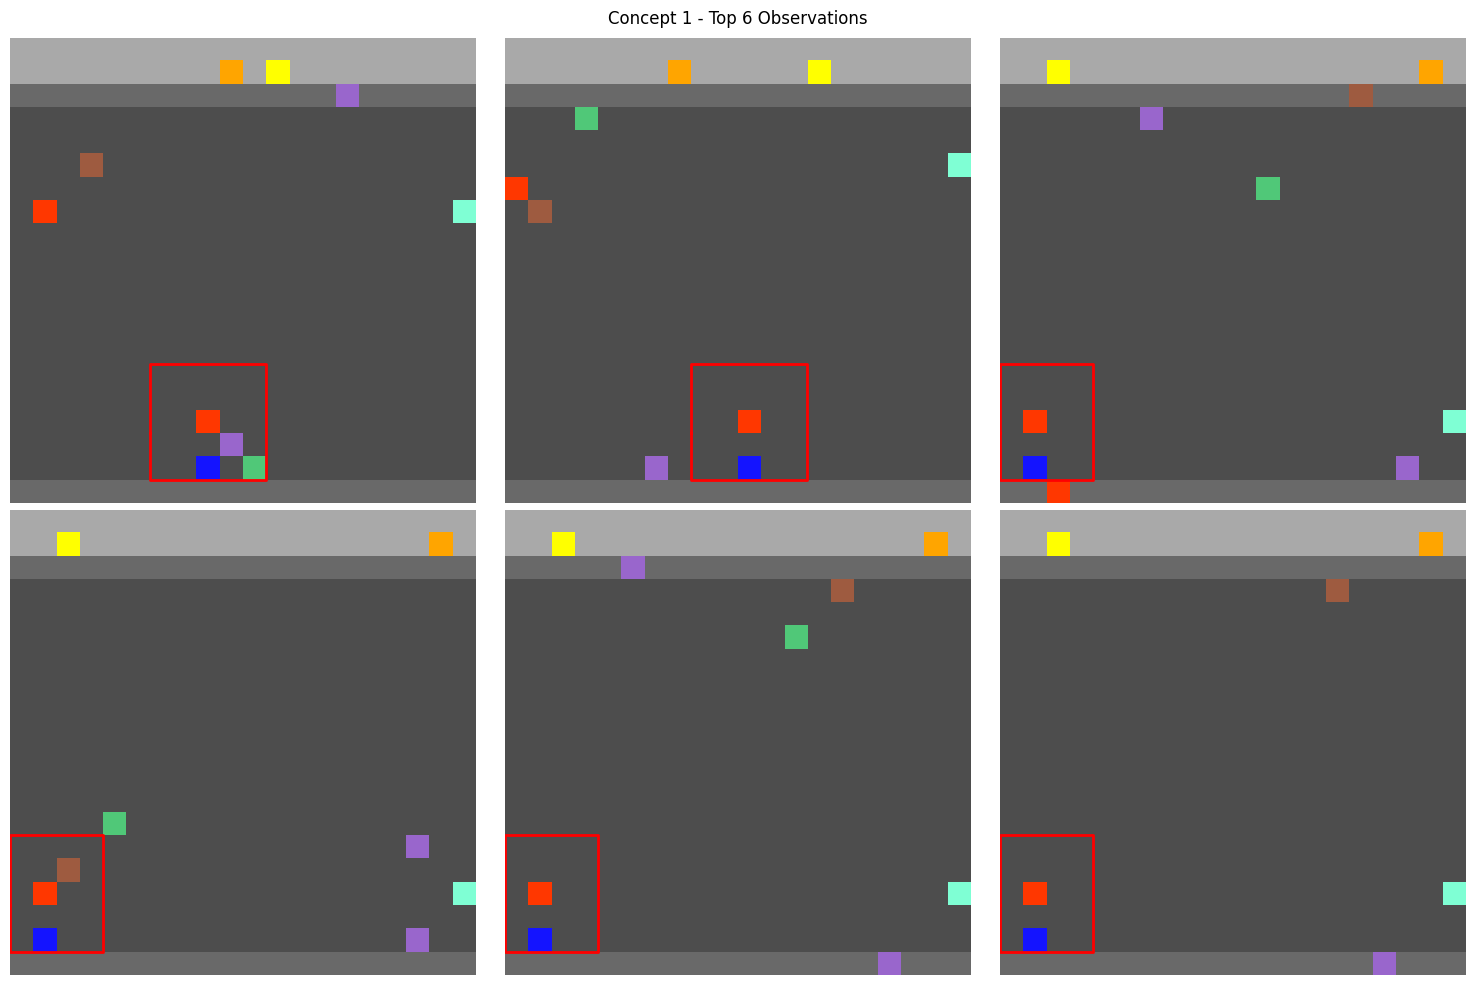

GemCollector - ice
{'layer': 1, 'batch': 19, 'cavs_n': 49, 'matched_index': 0, 'cosine_similarity': 0.6433038711547852, 'manual_concept_name': 'amethyst_left_within_reach'}


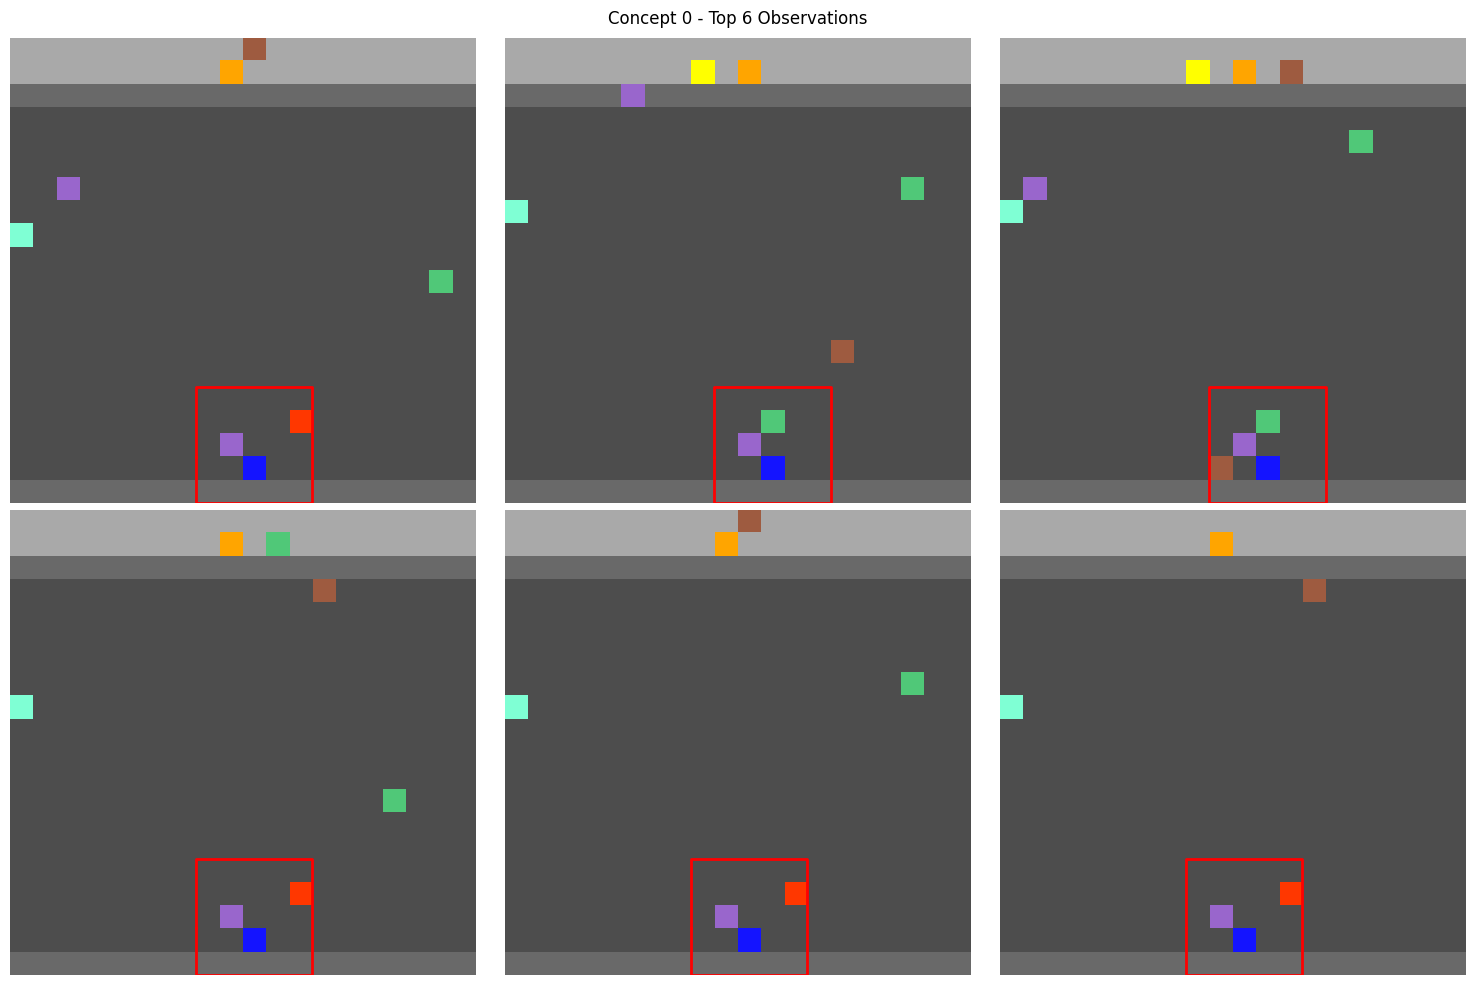

In [27]:
from keras.api.models import Sequential
from keras.api.saving import load_model
import pickle

gc_clustered_obs = np.load("../../rl_concept_discovery_data/class_datasets_model_of_interest/gem_collector/target_class_balanced_30000_shuffled_examples.npy")

gc_top_concepts_k_means = top_concepts["gem_collector"]["k_means"]

model: Sequential = load_model("../../models/GemCollector/denim-sweep-56/1738828803_model____0.3766avg____0.6576max____0.1570min.keras") # type: ignore



for concept_data in gc_top_concepts_k_means:
    gc_k_means_clustered_labels = np.load(f"/Volumes/work/rl_ace_data/concept_examples/k_means/gem_collector/model_of_interest_target_class_balanced_observations/batch_{concept_data['batch']}/layer_{concept_data['layer']}/k_{concept_data['cavs_n']}_cluster_labels.npy")
    gc_k_means_clustered_controids = np.load(f"/Volumes/work/rl_ace_data/concept_examples/k_means/gem_collector/model_of_interest_target_class_balanced_observations/batch_{concept_data['batch']}/layer_{concept_data['layer']}/k_{concept_data['cavs_n']}_cluster_centroids.npy")

    mao = ModelActivationObtainer(model=model, input_normalization_type="image")
    
    gc_clustered_obs_activations = mao.get_layer_activations(layer_index=concept_data['layer'], model_inputs=gc_clustered_obs, flatten=True)

    gc_k_means_clustered_distances = np.array([
        np.linalg.norm(gc_clustered_obs_activations[i] - gc_k_means_clustered_controids[label])
        for i, label in enumerate(gc_k_means_clustered_labels)
    ])

    print("GemCollector - k_means")
    print(concept_data)

    visualize_avg_cluster_observation(
        clustered_observations=gc_clustered_obs,
        clustered_observations_labels=gc_k_means_clustered_labels,
        distances=gc_k_means_clustered_distances,
        clusters_to_show=[concept_data["matched_index"]]
    )

gc_top_concepts_fc_means = top_concepts["gem_collector"]["fc_means"]

for concept_data in gc_top_concepts_fc_means:
    gc_fc_means_clustered_labels = np.load(f"/Volumes/work/rl_ace_data/concept_examples/fc_means/gem_collector/model_of_interest_target_class_balanced_observations/batch_{concept_data['batch']}/layer_{concept_data['layer']}/c_{concept_data['cavs_n']}_hard_cluster_labels.npy")
    gc_fc_means_clustered_controids = np.load(f"/Volumes/work/rl_ace_data/concept_examples/fc_means/gem_collector/model_of_interest_target_class_balanced_observations/batch_{concept_data['batch']}/layer_{concept_data['layer']}/c_{concept_data['cavs_n']}_cluster_centroids.npy")

    mao = ModelActivationObtainer(model=model, input_normalization_type="image")
    
    gc_clustered_obs_activations = mao.get_layer_activations(layer_index=concept_data['layer'], model_inputs=gc_clustered_obs, flatten=True)

    fc_means_clustered_distances = np.array([
        np.linalg.norm(gc_clustered_obs_activations[i] - gc_fc_means_clustered_controids[label])
        for i, label in enumerate(gc_fc_means_clustered_labels)
    ])

    print("GemCollector - fc_means")
    print(concept_data)

    visualize_avg_cluster_observation(
        clustered_observations=gc_clustered_obs,
        clustered_observations_labels=gc_fc_means_clustered_labels,
        distances=fc_means_clustered_distances,
        clusters_to_show=[concept_data["matched_index"]]
    )

gc_top_concepts_ice = top_concepts["gem_collector"]["ice"]

for concept_data in gc_top_concepts_ice:

    topk_pickle_path = (
        f"/Volumes/work/rl_ice_data/ncavs/gem_collector/model_of_interest_target_class_balanced_observations/batch_{concept_data['batch']}/layer_{concept_data['layer']}/c_{concept_data['cavs_n']}_topk_activations.pkl"
    )
    with open(topk_pickle_path, "rb") as f:
        topk_activation_dict = pickle.load(f)

    filtered_topk_activation_dict = {
        k: v for k, v in topk_activation_dict.items() if int(k) in [concept_data["matched_index"]]
    }

    print("GemCollector - ice")
    print(concept_data)

    visualize_ice_concept(topk_activation_dict=filtered_topk_activation_dict, discovery_observations=gc_clustered_obs)
    

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Minecart Counter - k_means {'layer': 5, 'batch': 13, 'cavs_n': 50, 'matched_index': 7, 'cosine_similarity': 0.7679722309112549, 'manual_concept_name': 'minecarts_n'}


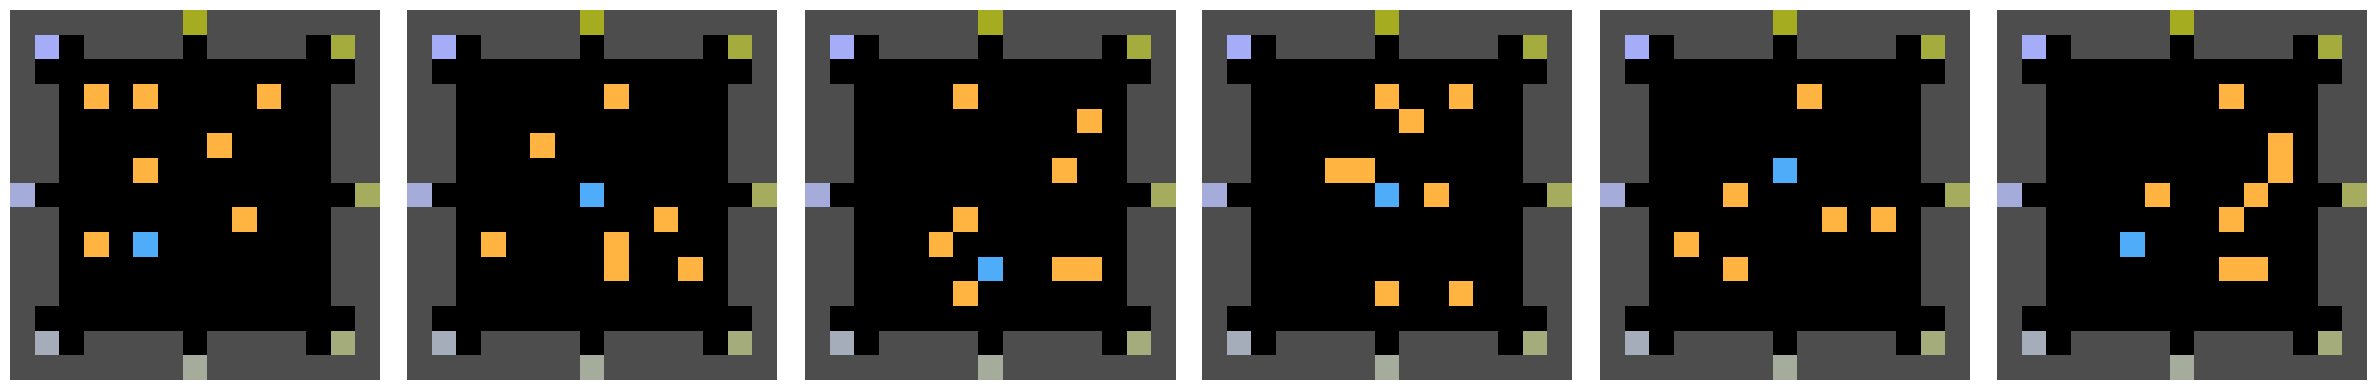

938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Minecart Counter - k_means {'layer': 5, 'batch': 13, 'cavs_n': 50, 'matched_index': 49, 'cosine_similarity': 0.5478354692459106, 'manual_concept_name': 'goal_1_right'}


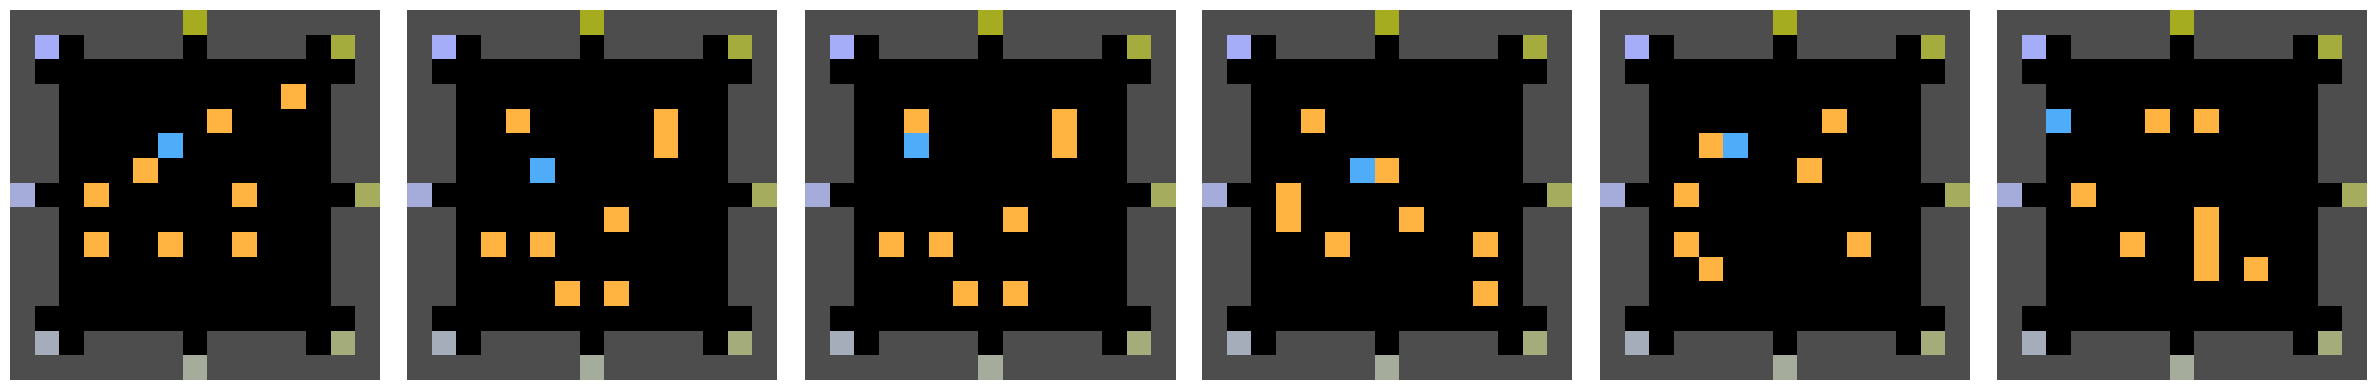

938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Minecart Counter - fc_means {'layer': 5, 'batch': 30, 'cavs_n': 47, 'matched_index': 27, 'cosine_similarity': 0.6768322357125883, 'manual_concept_name': 'minecarts_n'}


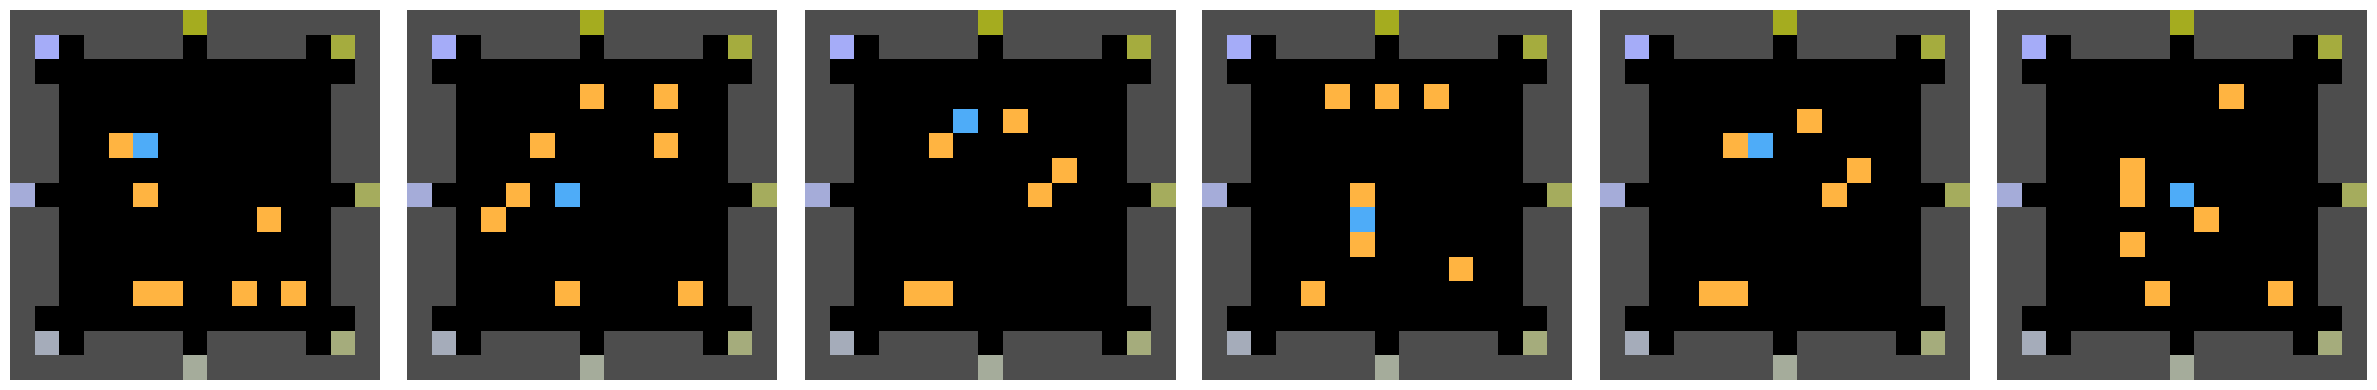

938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Minecart Counter - fc_means {'layer': 5, 'batch': 30, 'cavs_n': 47, 'matched_index': 36, 'cosine_similarity': 0.4761354108275395, 'manual_concept_name': 'goal_5_right'}


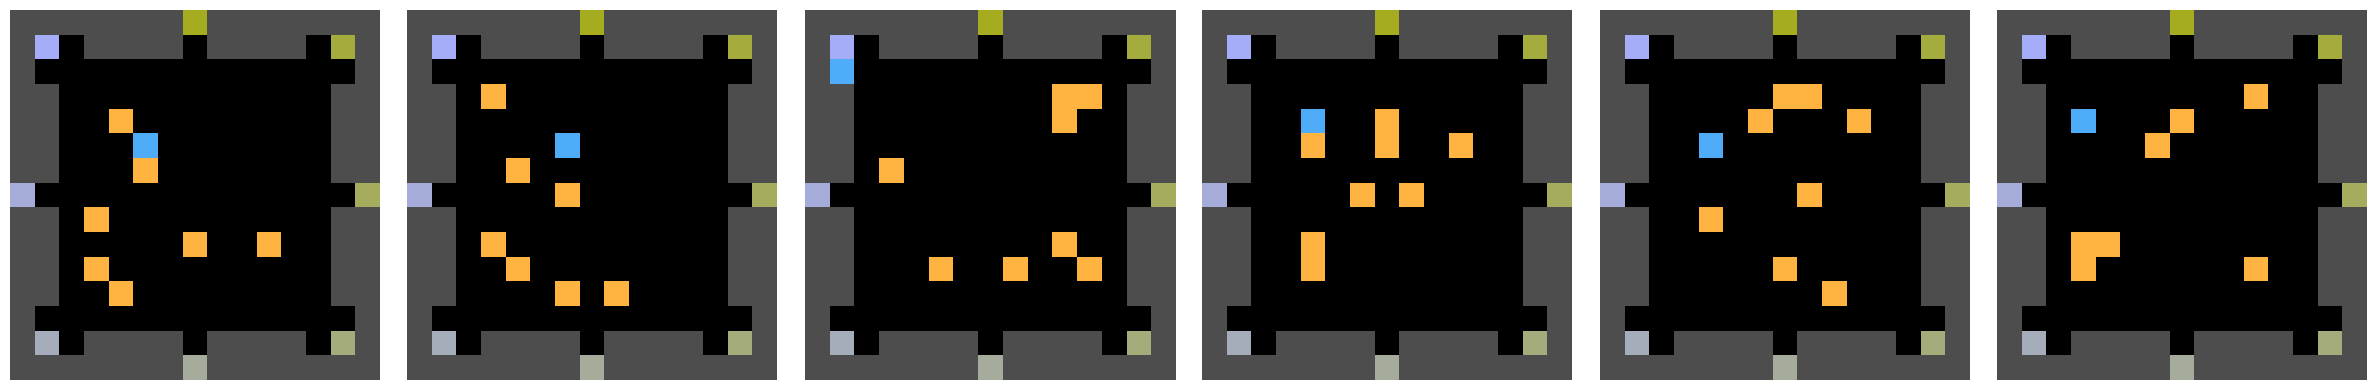

GemCollector - ice
{'layer': 1, 'batch': 28, 'cavs_n': 2, 'matched_index': 1, 'cosine_similarity': 0.8010883927345276, 'manual_concept_name': 'minecarts_n'}


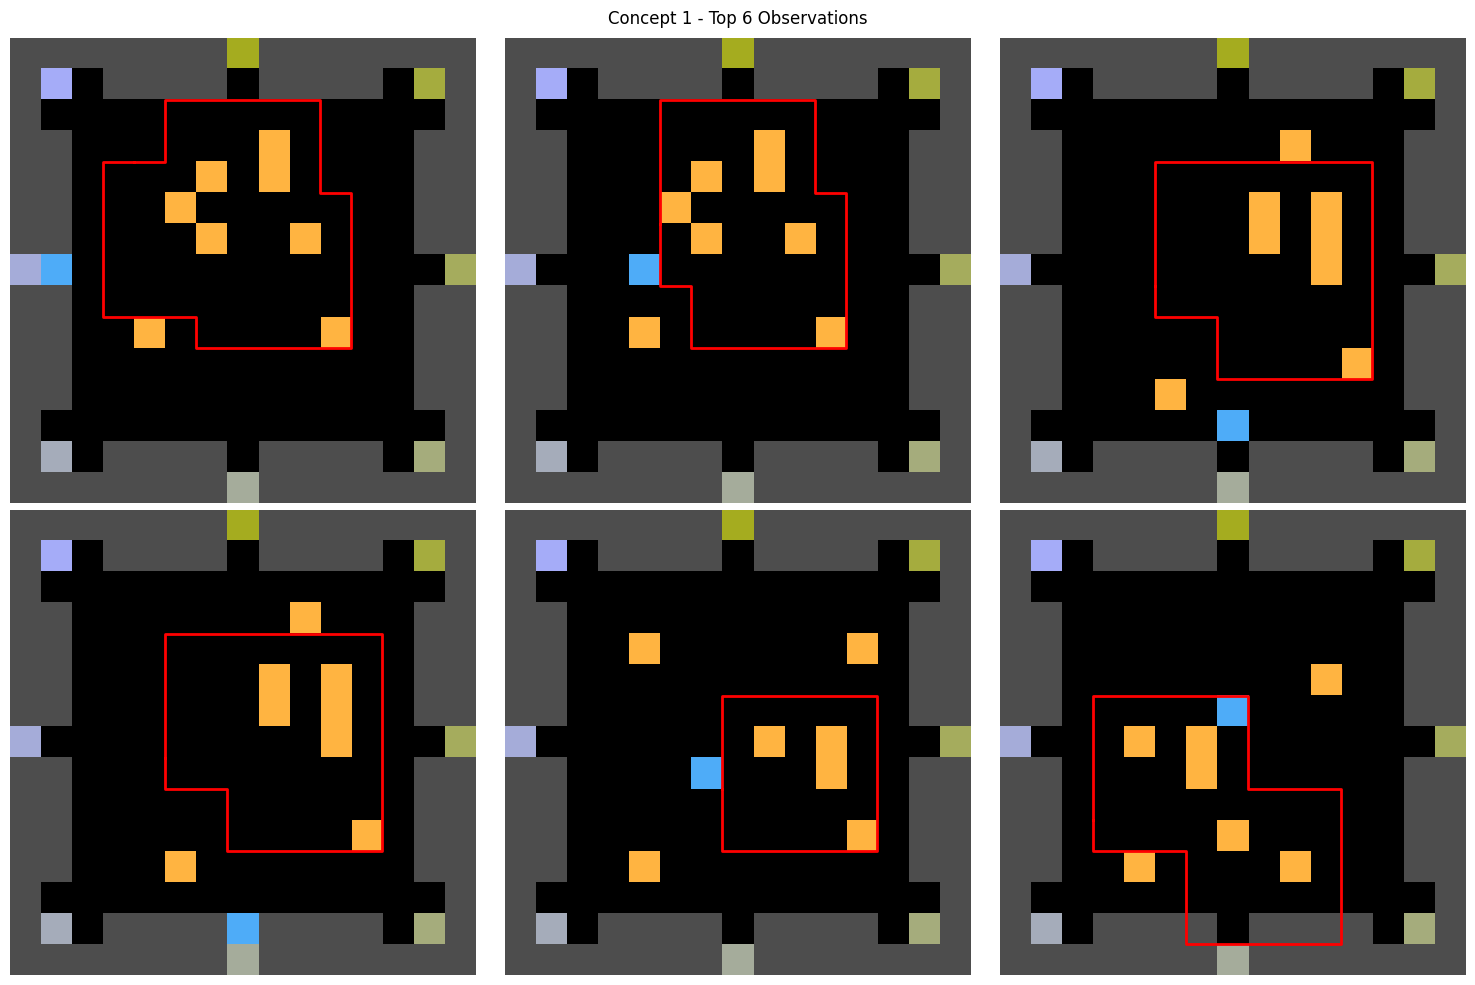

GemCollector - ice
{'layer': 1, 'batch': 93, 'cavs_n': 36, 'matched_index': 32, 'cosine_similarity': 0.7425113320350647, 'manual_concept_name': 'wall_1_up_left'}


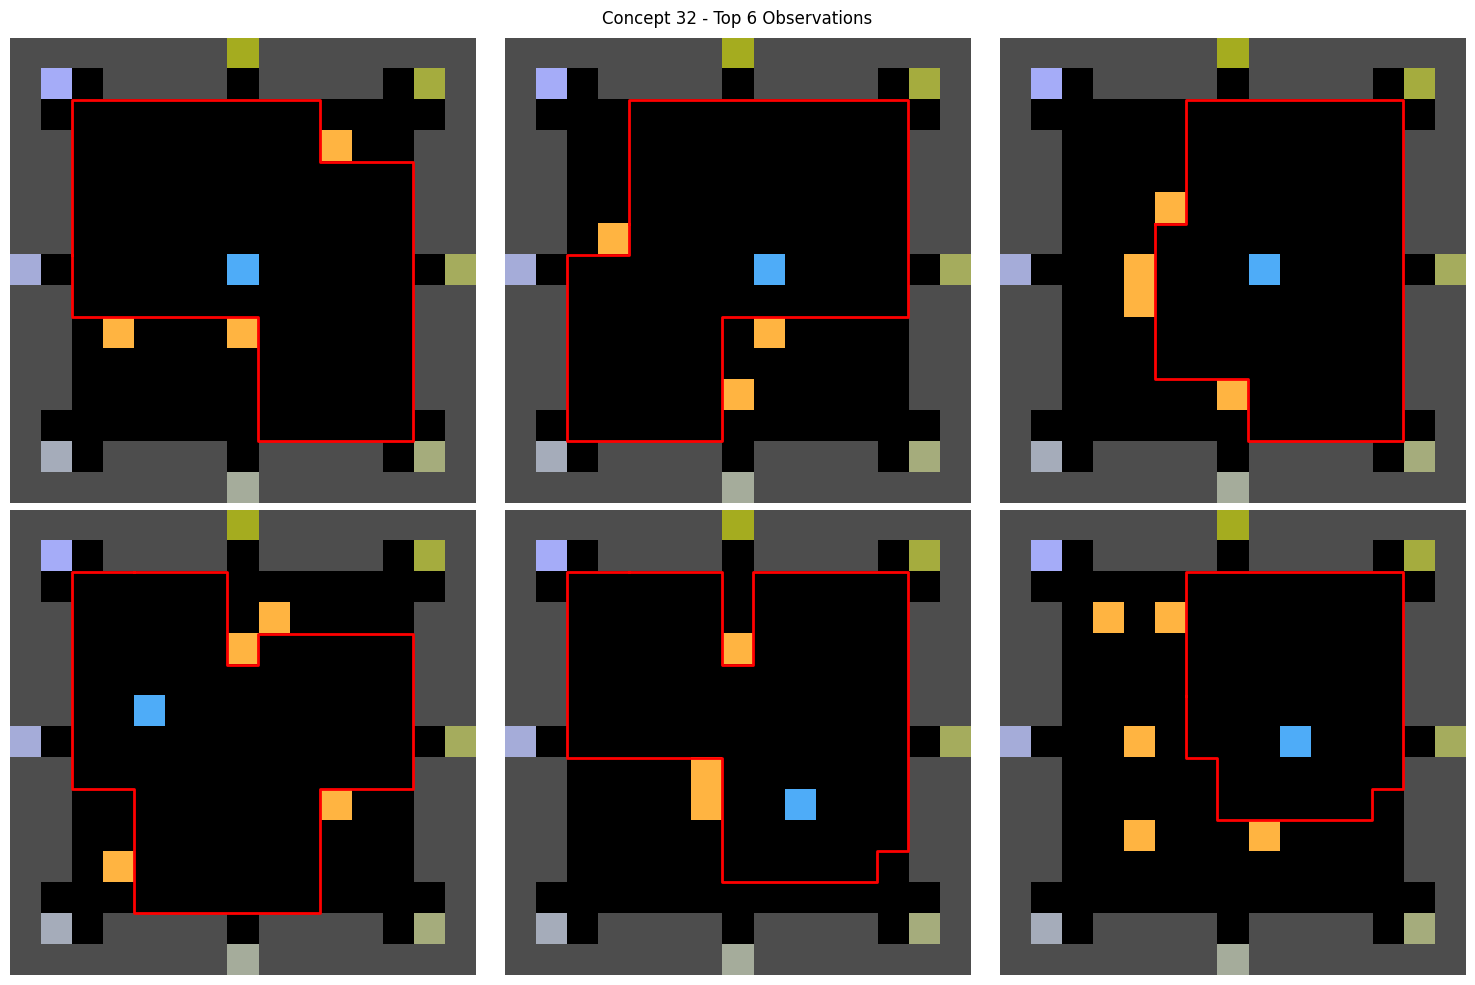

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from keras.api.models import Sequential
from keras.api.saving import load_model

mc_clustered_obs = np.load(
    "../../rl_concept_discovery_data/class_datasets_model_of_interest/"
    "minecart_counter/target_class_balanced_30000_shuffled_examples.npy"
)

mc_top_concepts_k_means = top_concepts["minecart_counter"]["k_means"]
model: Sequential = load_model(
    "../../models/MinecartCounter/"
    "kind-cosmos-35/1740021317_model____0.5122avg____0.9750max___-0.0900min.keras"
)  # type: ignore
mao = ModelActivationObtainer(model=model, input_normalization_type="image")

# ---- k_means: pick 3 obs whose activations are closest to the centroid ----
for concept_data in mc_top_concepts_k_means:
    batch = concept_data["batch"]
    layer = concept_data["layer"]
    cavs_n = concept_data["cavs_n"]
    match_idx = concept_data["matched_index"]

    labels = np.load(
        f"/Volumes/work/rl_ace_data/concept_examples/k_means/"
        f"minecart_counter/model_of_interest_target_class_balanced_observations/"
        f"batch_{batch}/layer_{layer}/k_{cavs_n}_cluster_labels.npy"
    )
    centroids = np.load(
        f"/Volumes/work/rl_ace_data/concept_examples/k_means/"
        f"minecart_counter/model_of_interest_target_class_balanced_observations/"
        f"batch_{batch}/layer_{layer}/k_{cavs_n}_cluster_centroids.npy"
    )

    acts = mao.get_layer_activations(
        layer_index=layer,
        model_inputs=mc_clustered_obs,
        flatten=True
    )
    # full-array distances for all points
    all_distances = np.array([
        np.linalg.norm(acts[i] - centroids[label])
        for i, label in enumerate(labels)
    ])

    # get indices in this cluster
    cluster_idxs = np.where(labels == match_idx)[0]
    if len(cluster_idxs) == 0:
        continue

    # sort them by distance and pick 3 closest
    sorted_cluster = cluster_idxs[np.argsort(all_distances[cluster_idxs])]
    sel_idxs = sorted_cluster[:6]
    sel_images = mc_clustered_obs[sel_idxs]

    print("Minecart Counter - k_means", concept_data)
    fig, axes = plt.subplots(1, len(sel_images), figsize=(4 * len(sel_images), 4))
    if len(sel_images) == 1:
        axes = [axes]
    for i, img in enumerate(sel_images):
        axes[i].imshow(img.astype(np.uint8))
        #axes[i].set_title(f"Concept {match_idx} – Closest {i+1}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


# ---- fc_means: same idea ----
mc_top_concepts_fc_means = top_concepts["minecart_counter"]["fc_means"]
for concept_data in mc_top_concepts_fc_means:
    batch = concept_data["batch"]
    layer = concept_data["layer"]
    cavs_n = concept_data["cavs_n"]
    match_idx = concept_data["matched_index"]

    labels = np.load(
        f"/Volumes/work/rl_ace_data/concept_examples/fc_means/"
        f"minecart_counter/model_of_interest_target_class_balanced_observations/"
        f"batch_{batch}/layer_{layer}/c_{cavs_n}_hard_cluster_labels.npy"
    )
    centroids = np.load(
        f"/Volumes/work/rl_ace_data/concept_examples/fc_means/"
        f"minecart_counter/model_of_interest_target_class_balanced_observations/"
        f"batch_{batch}/layer_{layer}/c_{cavs_n}_cluster_centroids.npy"
    )

    acts = mao.get_layer_activations(
        layer_index=layer,
        model_inputs=mc_clustered_obs,
        flatten=True
    )
    all_distances = np.array([
        np.linalg.norm(acts[i] - centroids[label])
        for i, label in enumerate(labels)
    ])

    cluster_idxs = np.where(labels == match_idx)[0]
    if len(cluster_idxs) == 0:
        continue

    sorted_cluster = cluster_idxs[np.argsort(all_distances[cluster_idxs])]
    sel_idxs = sorted_cluster[:6]
    sel_images = mc_clustered_obs[sel_idxs]

    print("Minecart Counter - fc_means", concept_data)
    fig, axes = plt.subplots(1, len(sel_images), figsize=(4 * len(sel_images), 4))
    if len(sel_images) == 1:
        axes = [axes]
    for i, img in enumerate(sel_images):
        axes[i].imshow(img.astype(np.uint8))
        #axes[i].set_title(f"Concept {match_idx} – Closest {i+1}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

mc_top_concepts_ice = top_concepts["minecart_counter"]["ice"]

for concept_data in mc_top_concepts_ice:

    topk_pickle_path = (
        f"/Volumes/work/rl_ice_data/ncavs/minecart_counter/model_of_interest_target_class_balanced_observations/batch_{concept_data['batch']}/layer_{concept_data['layer']}/c_{concept_data['cavs_n']}_topk_activations.pkl"
    )
    with open(topk_pickle_path, "rb") as f:
        topk_activation_dict = pickle.load(f)

    filtered_topk_activation_dict = {
        k: v for k, v in topk_activation_dict.items() if int(k) in [concept_data["matched_index"]]
    }

    print("GemCollector - ice")
    print(concept_data)

    visualize_ice_concept(topk_activation_dict=filtered_topk_activation_dict, discovery_observations=mc_clustered_obs)
    

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Gold Run Mini - k_means {'layer': 1, 'batch': 65, 'cavs_n': 4, 'matched_index': 3, 'cosine_similarity': 0.6310579776763916, 'manual_concept_name': 'purple_exit_down'}


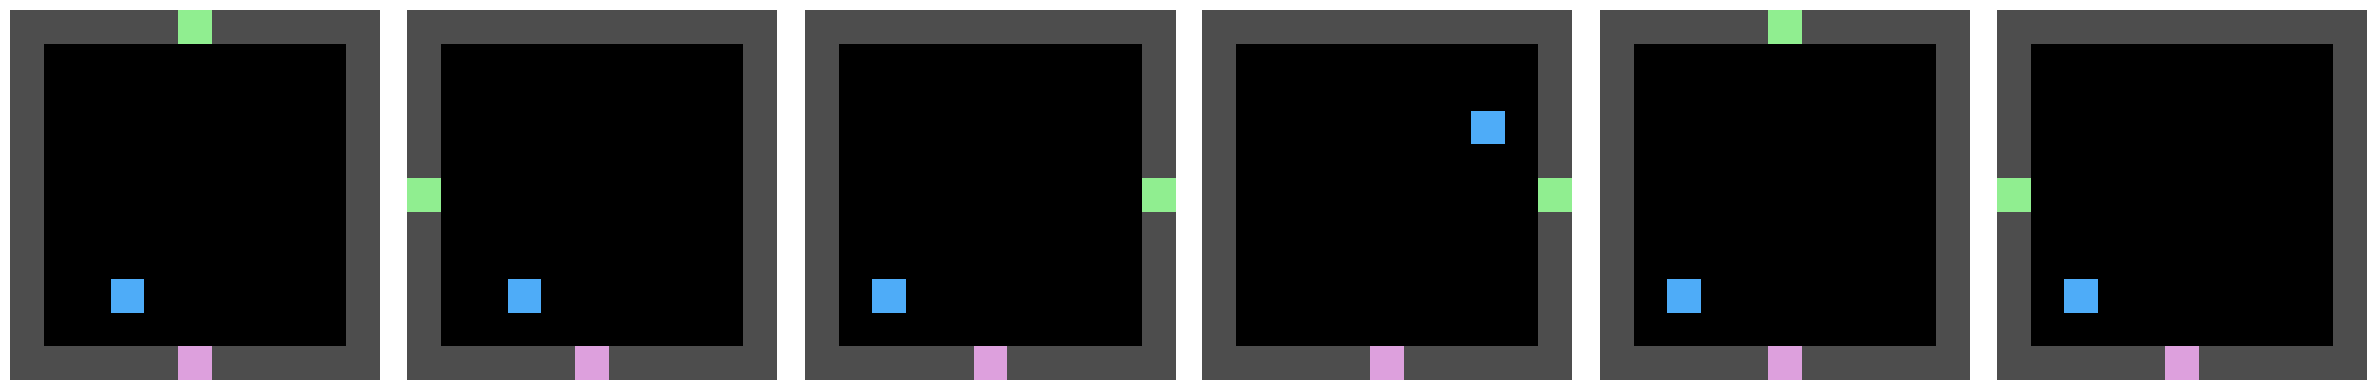

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Gold Run Mini - k_means {'layer': 1, 'batch': 65, 'cavs_n': 4, 'matched_index': 0, 'cosine_similarity': 0.6138845682144165, 'manual_concept_name': 'wall_directly_left'}


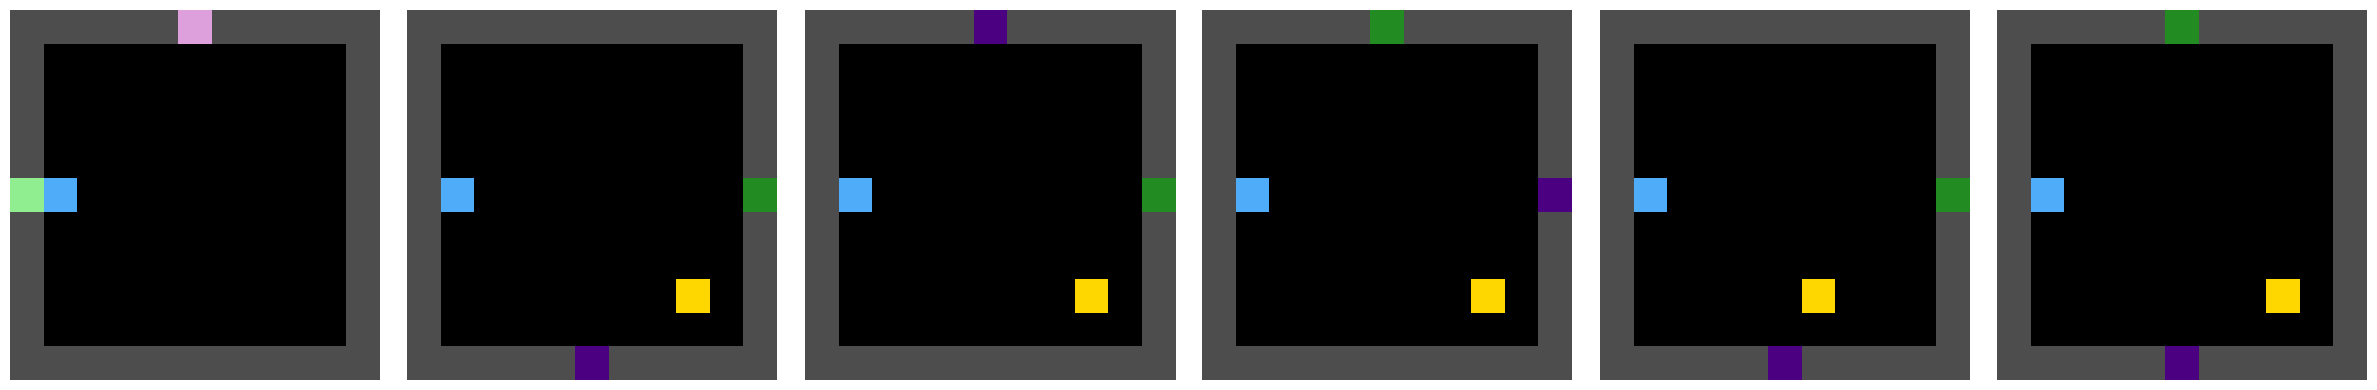

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Gold Run Mini - fc_means {'layer': 4, 'batch': 37, 'cavs_n': 50, 'matched_index': 0, 'cosine_similarity': 0.3943479564544477, 'manual_concept_name': 'gold_right'}


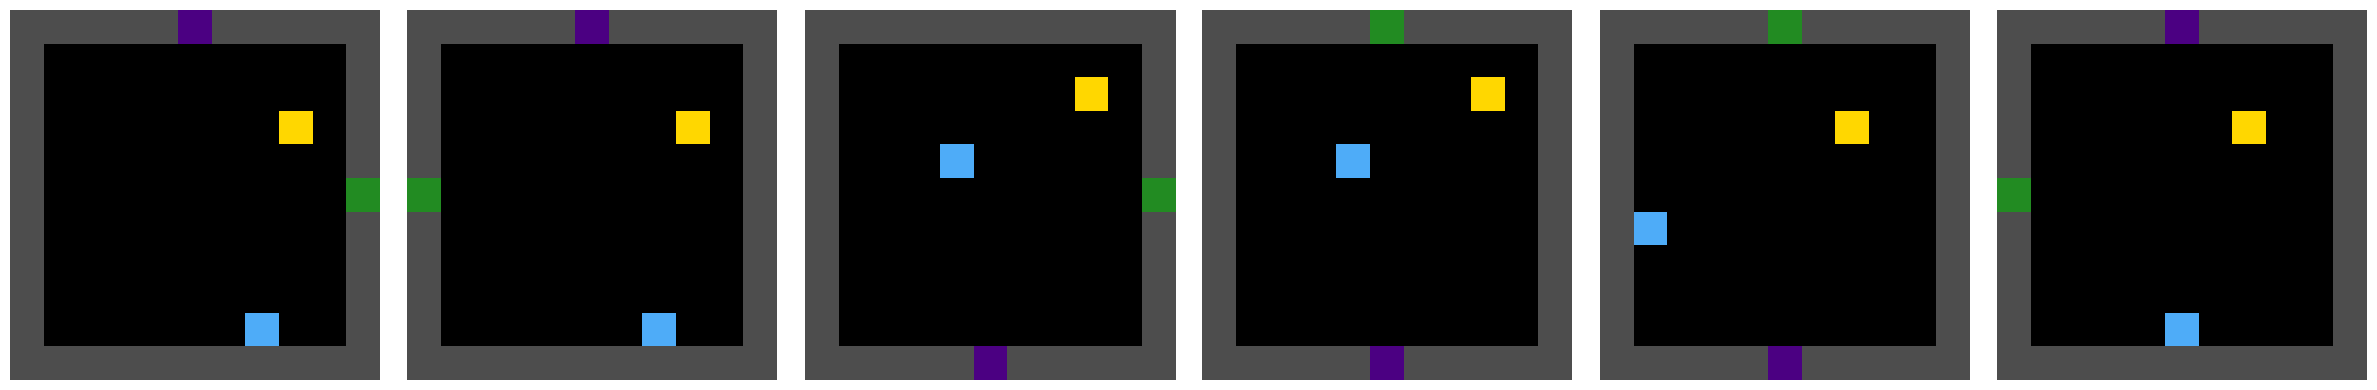

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Gold Run Mini - fc_means {'layer': 5, 'batch': 26, 'cavs_n': 50, 'matched_index': 10, 'cosine_similarity': 0.2569896807432701, 'manual_concept_name': 'gold_down'}


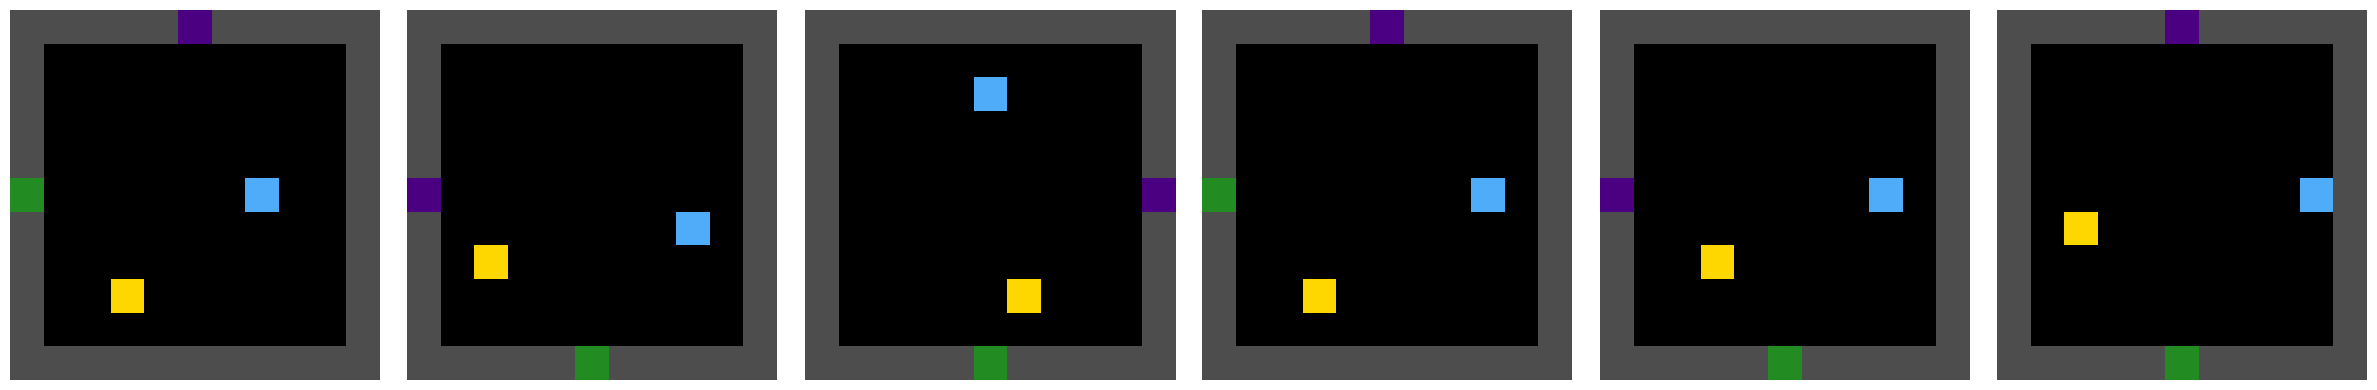

Gold Run Mini - ice
{'layer': 1, 'batch': 53, 'cavs_n': 2, 'matched_index': 1, 'cosine_similarity': 0.7544534206390381, 'manual_concept_name': 'gold_left'}


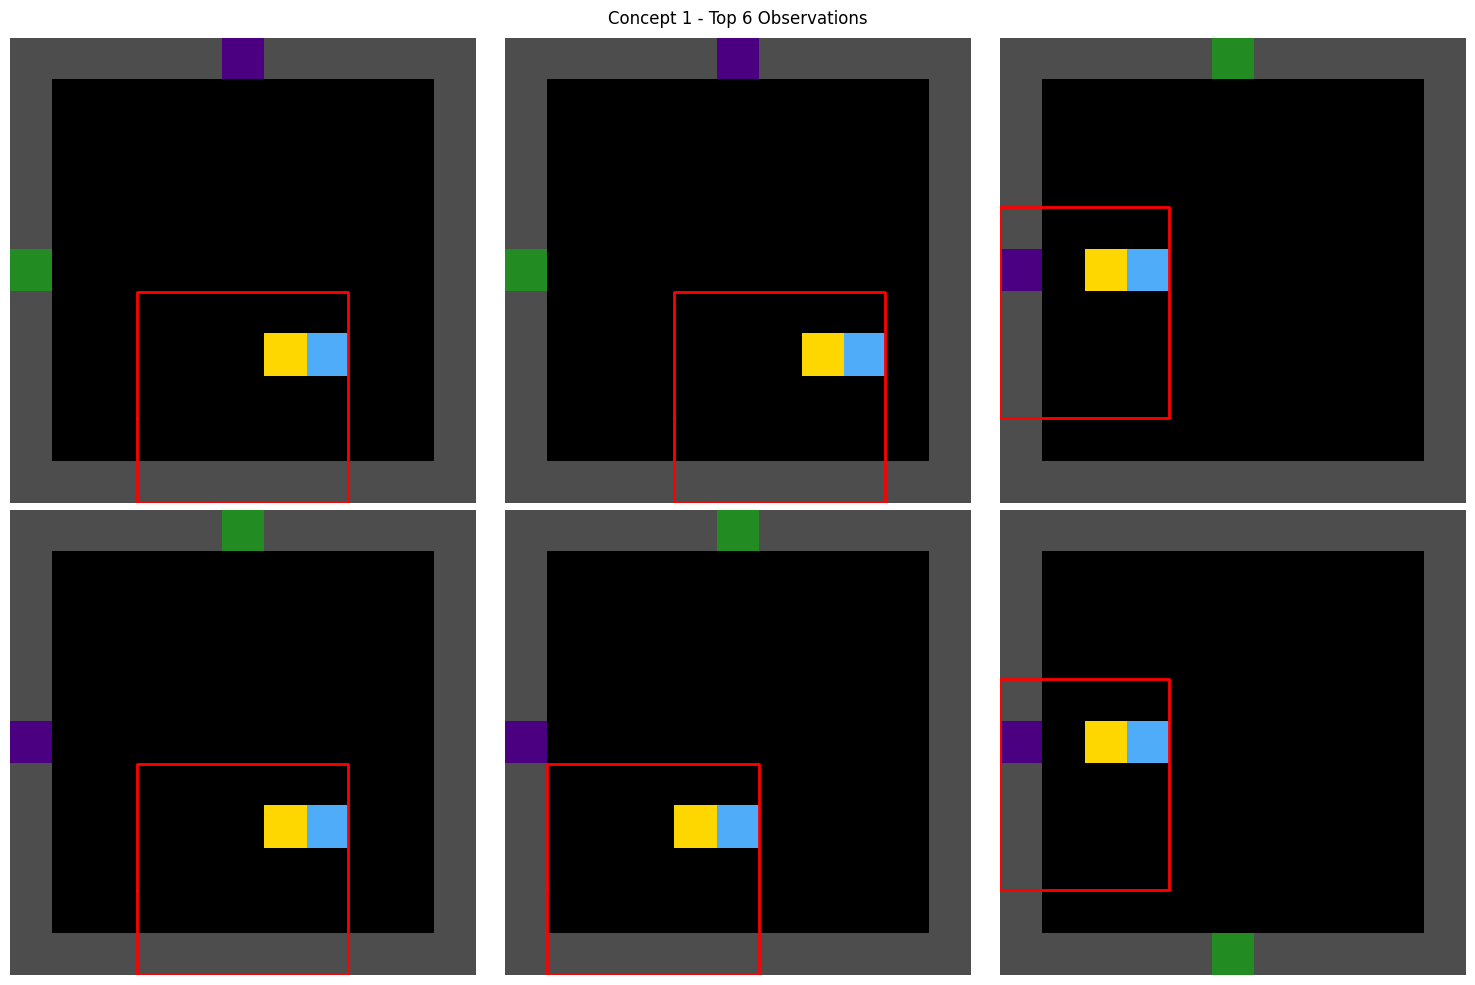

Gold Run Mini - ice
{'layer': 1, 'batch': 51, 'cavs_n': 50, 'matched_index': 19, 'cosine_similarity': 0.7521727681159973, 'manual_concept_name': 'purple_exit_down'}


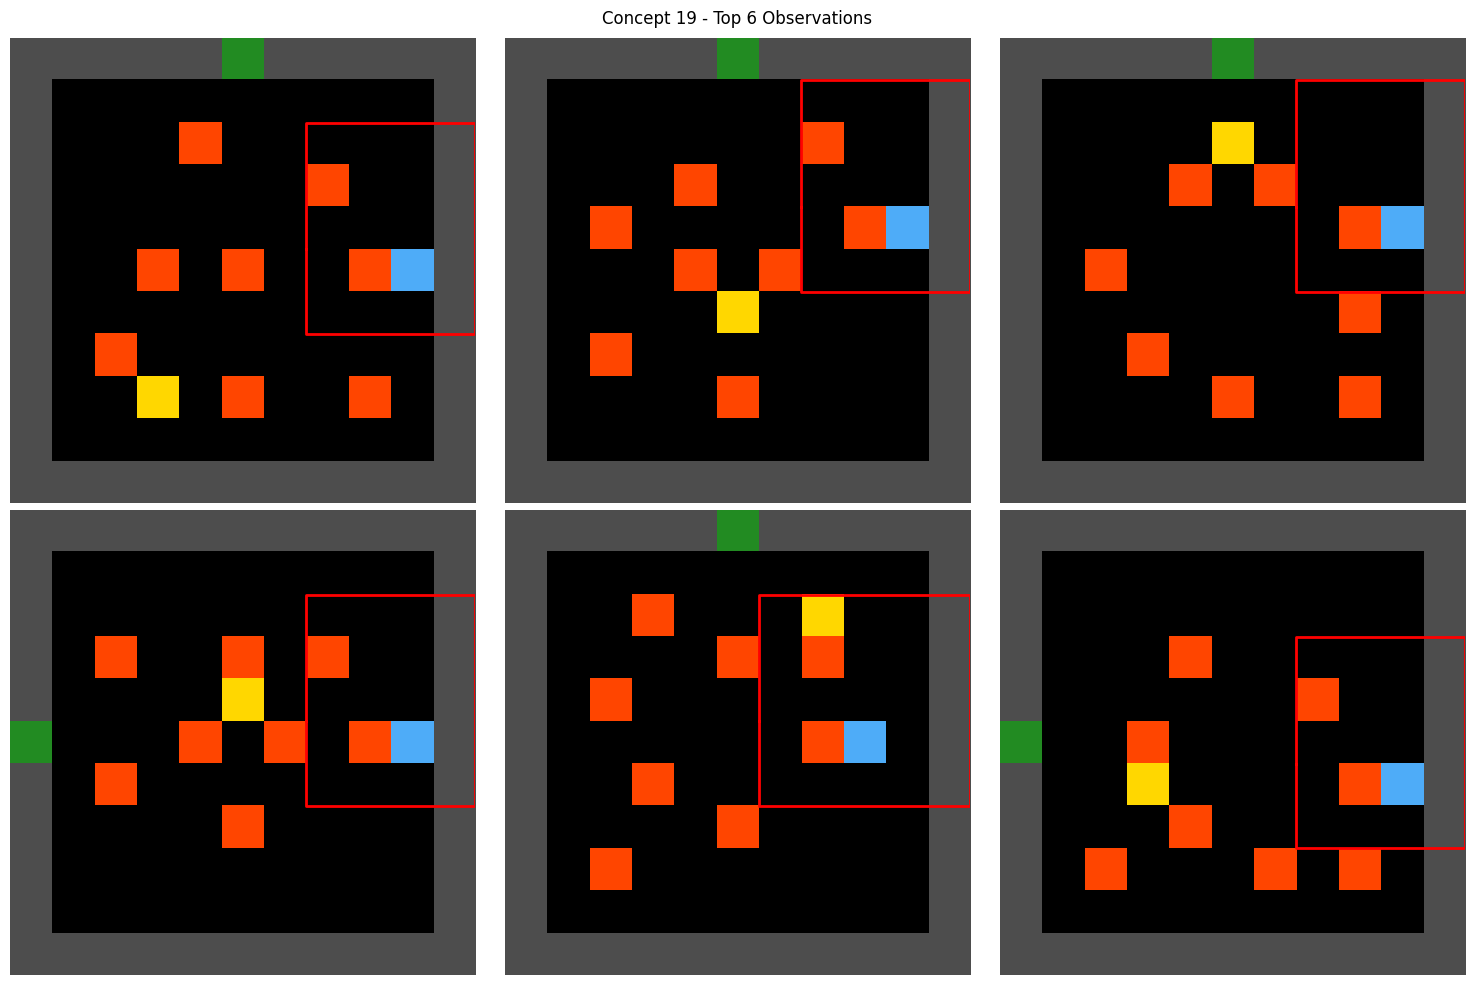

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from keras.api.models import Sequential
from keras.api.saving import load_model

grm_clustered_obs = np.load(
    "../../rl_concept_discovery_data/class_datasets_model_of_interest/"
    "gold_run_mini/target_class_balanced_6900_shuffled_examples.npy"
)

grm_top_concepts_k_means = top_concepts["gold_run_mini"]["k_means"]
model: Sequential = load_model(
    "../../models/GoldRunMini/sub-competent/firm-mountain-13/model_time_step_457199_episode_15800____0.4878avg____0.5000max____0.4532min.keras"
)  # type: ignore
mao = ModelActivationObtainer(model=model, input_normalization_type="image")

# ---- k_means: pick 3 obs whose activations are closest to the centroid ----
for concept_data in grm_top_concepts_k_means:
    batch = concept_data["batch"]
    layer = concept_data["layer"]
    cavs_n = concept_data["cavs_n"]
    match_idx = concept_data["matched_index"]

    labels = np.load(
        f"/Volumes/work/rl_ace_data/concept_examples/k_means/"
        f"gold_run_mini/model_of_interest_target_class_balanced_observations/"
        f"batch_{batch}/layer_{layer}/k_{cavs_n}_cluster_labels.npy"
    )
    centroids = np.load(
        f"/Volumes/work/rl_ace_data/concept_examples/k_means/"
        f"gold_run_mini/model_of_interest_target_class_balanced_observations/"
        f"batch_{batch}/layer_{layer}/k_{cavs_n}_cluster_centroids.npy"
    )

    acts = mao.get_layer_activations(
        layer_index=layer,
        model_inputs=grm_clustered_obs,
        flatten=True
    )
    # full-array distances for all points
    all_distances = np.array([
        np.linalg.norm(acts[i] - centroids[label])
        for i, label in enumerate(labels)
    ])

    # get indices in this cluster
    cluster_idxs = np.where(labels == match_idx)[0]
    if len(cluster_idxs) == 0:
        continue

    # sort them by distance and pick 3 closest
    sorted_cluster = cluster_idxs[np.argsort(all_distances[cluster_idxs])]
    sel_idxs = sorted_cluster[:6]
    sel_images = grm_clustered_obs[sel_idxs]

    print("Gold Run Mini - k_means", concept_data)
    fig, axes = plt.subplots(1, len(sel_images), figsize=(4 * len(sel_images), 4))
    if len(sel_images) == 1:
        axes = [axes]
    for i, img in enumerate(sel_images):
        axes[i].imshow(img.astype(np.uint8))
        #axes[i].set_title(f"Concept {match_idx} – Closest {i+1}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


# ---- fc_means: same idea ----
grm_top_concepts_fc_means = top_concepts["gold_run_mini"]["fc_means"]
for concept_data in grm_top_concepts_fc_means:
    batch = concept_data["batch"]
    layer = concept_data["layer"]
    cavs_n = concept_data["cavs_n"]
    match_idx = concept_data["matched_index"]

    labels = np.load(
        f"/Volumes/work/rl_ace_data/concept_examples/fc_means/"
        f"gold_run_mini/model_of_interest_target_class_balanced_observations/"
        f"batch_{batch}/layer_{layer}/c_{cavs_n}_hard_cluster_labels.npy"
    )
    centroids = np.load(
        f"/Volumes/work/rl_ace_data/concept_examples/fc_means/"
        f"gold_run_mini/model_of_interest_target_class_balanced_observations/"
        f"batch_{batch}/layer_{layer}/c_{cavs_n}_cluster_centroids.npy"
    )

    acts = mao.get_layer_activations(
        layer_index=layer,
        model_inputs=grm_clustered_obs,
        flatten=True
    )
    all_distances = np.array([
        np.linalg.norm(acts[i] - centroids[label])
        for i, label in enumerate(labels)
    ])

    cluster_idxs = np.where(labels == match_idx)[0]
    if len(cluster_idxs) == 0:
        continue

    sorted_cluster = cluster_idxs[np.argsort(all_distances[cluster_idxs])]
    sel_idxs = sorted_cluster[:6]
    sel_images = grm_clustered_obs[sel_idxs]

    print("Gold Run Mini - fc_means", concept_data)
    fig, axes = plt.subplots(1, len(sel_images), figsize=(4 * len(sel_images), 4))
    if len(sel_images) == 1:
        axes = [axes]
    for i, img in enumerate(sel_images):
        axes[i].imshow(img.astype(np.uint8))
        #axes[i].set_title(f"Concept {match_idx} – Closest {i+1}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

grm_top_concepts_ice = top_concepts["gold_run_mini"]["ice"]

for concept_data in grm_top_concepts_ice:

    topk_pickle_path = (
        f"/Volumes/work/rl_ice_data/ncavs/gold_run_mini/model_of_interest_target_class_balanced_observations/batch_{concept_data['batch']}/layer_{concept_data['layer']}/c_{concept_data['cavs_n']}_topk_activations.pkl"
    )
    with open(topk_pickle_path, "rb") as f:
        topk_activation_dict = pickle.load(f)

    filtered_topk_activation_dict = {
        k: v for k, v in topk_activation_dict.items() if int(k) in [concept_data["matched_index"]]
    }

    print("Gold Run Mini - ice")
    print(concept_data)

    visualize_ice_concept(topk_activation_dict=filtered_topk_activation_dict, discovery_observations=grm_clustered_obs)
    